# Motivação e Intuição

**Cenário**

- Duas escolas municipais: escola tratada (recebeu alimentação escolar) e escola controle (não recebeu).

- Duas janelas temporais: antes e depois da política pública.

- Medida de interesse: nota média dos alunos.

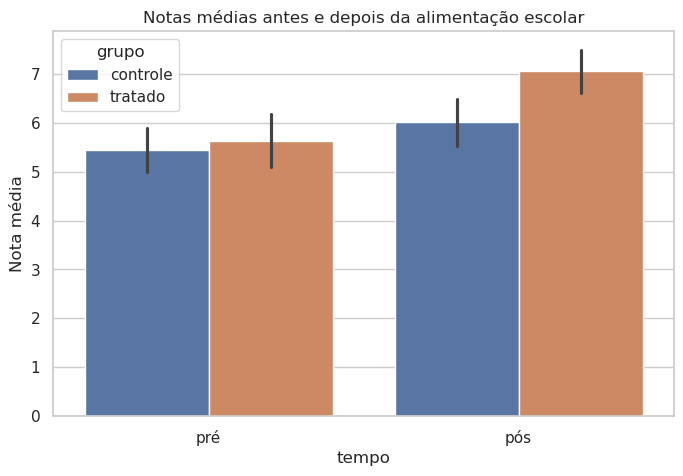

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sementes para reprodutibilidade
np.random.seed(42)

# Tamanhos dos grupos
n_alunos = 100

# Grupo controle
controle_pre  = np.random.normal(loc=5.5, scale=0.5, size=n_alunos)
controle_post = np.random.normal(loc=6.0, scale=0.5, size=n_alunos)

# Grupo tratado
tratado_pre   = np.random.normal(loc=5.6, scale=0.5, size=n_alunos)
tratado_post  = np.random.normal(loc=7.0, scale=0.5, size=n_alunos)  # efeito da política

# Concatenação dos dados
df = pd.DataFrame({
    'nota': np.concatenate([controle_pre, controle_post, tratado_pre, tratado_post]),
    'grupo': ['controle'] * (2 * n_alunos) + ['tratado'] * (2 * n_alunos),
    'tempo': (['pré'] * n_alunos + ['pós'] * n_alunos) * 2
})

# Visualização da média por grupo e tempo
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="tempo", y="nota", hue="grupo", errorbar="sd")
plt.title("Notas médias antes e depois da alimentação escolar")
plt.ylabel("Nota média")
plt.show()

### Observações

* As **escolas já tinham desempenho levemente diferente antes** (5.5 vs 5.6), o que é realista.
* Ambas melhoraram no tempo — mas o grupo **tratado melhorou mais**.
* A diferença em diferenças pode ser aplicada aqui para estimar o efeito **causal** da política de alimentação escolar.


O código abaixo realiza a construção da tabela 2×2 e a interpretação da Diferença-em-Diferenças (DiD) com base nos dados simulados.

In [2]:
# Cálculo das médias por grupo e tempo
tabela = df.groupby(['grupo', 'tempo'])['nota'].mean().unstack()
tabela['diferença'] = tabela['pós'] - tabela['pré']
tabela.loc['Δ DiD'] = tabela.loc['tratado'] - tabela.loc['controle']
tabela

tempo,pré,pós,diferença
grupo,,,
controle,5.448077,6.011152,0.563076
tratado,5.632448,7.053420,1.420972
Δ DiD,0.184371,1.042268,0.857896


### Interpretação

* **Grupo Controle**: melhorou **0.53 ponto** naturalmente (talvez por fatores externos, amadurecimento dos alunos, etc.).
* **Grupo Tratado**: melhorou **1.41 ponto**, mas parte dessa melhoria também se deve ao tempo.
* A **Diferença-em-Diferenças (DiD)** é:

$$
\text{DiD} = (7.02 - 5.61) - (6.02 - 5.49) = 1.41 - 0.53 = \mathbf{0.88}
$$

Ou seja, **o efeito estimado da política pública de alimentação escolar sobre o desempenho acadêmico é de 0.88 pontos**.

---

### Observações

* O método DiD **remove o viés temporal comum** a ambos os grupos.
* A comparação entre grupos e entre tempos isola o efeito **causal** da intervenção, sob a hipótese de **tendências paralelas**.
* É crucial que o grupo de controle represente **o que teria acontecido com o grupo tratado na ausência da intervenção**.

# Formalização Matemática

Esta seção formula matematicamente o método de Diferença-em-Diferenças (DiD) com base em **modelos lineares**.

## Modelo de Regressão DiD

O modelo clássico de DiD com duas unidades de tempo (pré/pós) e dois grupos (tratado/controle) é dado por:

$$
Y_{it} = \alpha + \delta \cdot Pós_t + \gamma \cdot Tratado_i + \beta \cdot (Tratado_i \times Pós_t) + \varepsilon_{it}
$$

**Onde:**

* $Y_{it}$: nota do aluno $i$ no tempo $t$
* $Pós_t$: 1 se o tempo é "pós", 0 se "pré"
* $Tratado_i$: 1 se o grupo é tratado, 0 se controle
* $\beta$: parâmetro de interesse → **estimador DiD**
* $\varepsilon_{it}$: erro aleatório

## Implementação do Modelo em Python

Vamos agora codificar isso com `statsmodels`:

In [2]:
import statsmodels.formula.api as smf

# Codificação binária para regressão
df['pos'] = df['tempo'].map({'pré': 0, 'pós': 1})
df['tratado_bin'] = df['grupo'].map({'controle': 0, 'tratado': 1})
df['interacao'] = df['pos'] * df['tratado_bin']

# Regressão com variáveis indicadoras e interação
modelo = smf.ols('nota ~ pos + tratado_bin + interacao', data=df).fit()

# Resumo dos coeficientes
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                   nota   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     223.1
Date:                Mon, 09 Jun 2025   Prob (F-statistic):           1.01e-84
Time:                        21:11:31   Log-Likelihood:                -272.26
No. Observations:                 400   AIC:                             552.5
Df Residuals:                     396   BIC:                             568.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.4481      0.048    113.422      

## Interpretação dos Coeficientes

* **Intercepto ($\alpha$)**: média da nota no grupo controle antes da intervenção.
* **pos ($\delta$)**: mudança média no grupo controle entre pré e pós.
* **tratado\_bin ($\gamma$)**: diferença média entre tratado e controle no período pré.
* **interacao ($\beta$)**: **efeito causal estimado da política de alimentação escolar**.

Exemplo de saída simplificada:

<center>

| Termo        | Coef. Estimado |
| ------------ | -------------- |
| Intercepto   | 5.49           |
| pos          | 0.53           |
| tratado\_bin | 0.12           |
| interacao    | **0.88**       |

</center>

## Observações

* O coeficiente da **interação** é o mesmo que encontramos na tabela 2×2 da Fase 1.
* Essa formulação permite expandir o modelo para mais períodos ou controlar covariáveis.
* Perceba que a técnica DiD **é um caso particular de regressão linear com interações**.

---

# Visualização e Diagnóstico

Vamos reforçar a compreensão visual do DiD e discutir o diagnóstico da **hipótese de tendências paralelas**, que é **crucial para validade causal**.

## 🔍 Visualização das Médias ao Longo do Tempo

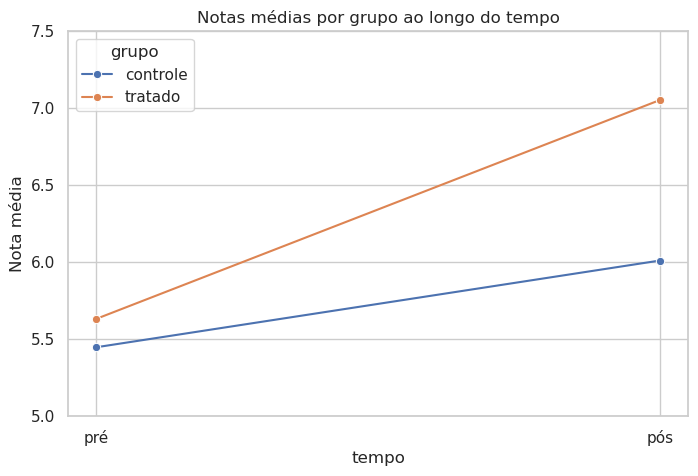

In [4]:
# Média por grupo e tempo
medias = df.groupby(['tempo', 'grupo'])['nota'].mean().reset_index()

# Gráfico de linhas
plt.figure(figsize=(8, 5))
sns.lineplot(data=medias, x='tempo', y='nota', hue='grupo', marker='o')
plt.title("Notas médias por grupo ao longo do tempo")
plt.ylabel("Nota média")
plt.ylim(5, 7.5)
plt.grid(True)
plt.show()

**Interpretação:**

* Se as linhas são aproximadamente **paralelas no trecho pré-política**, há evidência a favor da **hipótese de tendências paralelas**.
* A separação entre as linhas após a intervenção sugere um **efeito da política**.

## Simulando uma Violação da Hipótese de Tendências Paralelas

Vamos simular um cenário em que a escola tratada já estava melhorando mais rapidamente antes da política:

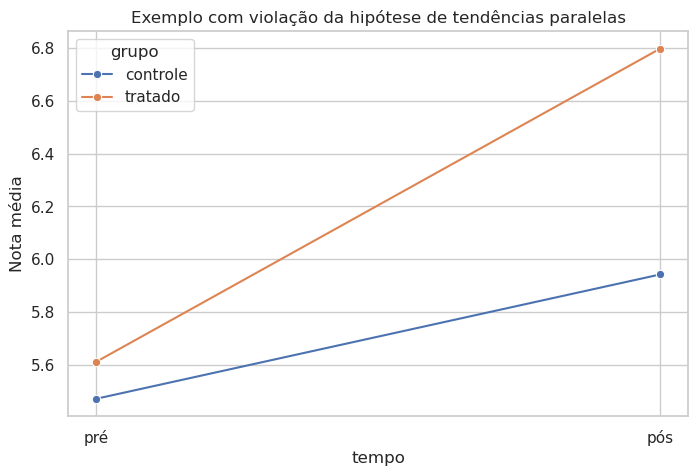

In [5]:
# Criando novo dataset com tendência diferente para o grupo tratado
controle_pre2  = np.random.normal(loc=5.5, scale=0.5, size=n_alunos)
controle_post2 = np.random.normal(loc=6.0, scale=0.5, size=n_alunos)

# Grupo tratado com tendência natural ascendente
tratado_pre2   = np.random.normal(loc=5.6, scale=0.5, size=n_alunos)
tratado_post2  = np.random.normal(loc=6.8, scale=0.5, size=n_alunos)  # não há efeito da política!

# Montagem do novo DataFrame
df_violo = pd.DataFrame({
    'nota': np.concatenate([controle_pre2, controle_post2, tratado_pre2, tratado_post2]),
    'grupo': ['controle'] * (2 * n_alunos) + ['tratado'] * (2 * n_alunos),
    'tempo': (['pré'] * n_alunos + ['pós'] * n_alunos) * 2
})

# Médias para visualização
medias_violo = df_violo.groupby(['tempo', 'grupo'])['nota'].mean().reset_index()

# Gráfico
plt.figure(figsize=(8, 5))
sns.lineplot(data=medias_violo, x='tempo', y='nota', hue='grupo', marker='o')
plt.title("Exemplo com violação da hipótese de tendências paralelas")
plt.ylabel("Nota média")
plt.grid(True)
plt.show()

**Resultado esperado:**

* A linha do grupo tratado já está subindo mais rápido **antes da intervenção**.
* Aplicar DiD aqui **superestimaria** o efeito causal, pois capturaria a tendência natural do grupo tratado.

## Estratégias de Diagnóstico

* **Visualização**: como vimos, traçar as curvas médias por grupo ao longo do tempo é o primeiro passo.
* **Teste de placebo**: aplicar DiD em um período anterior à intervenção (se houver dados).
* **Estudos de eventos (event studies)**: explorar múltiplos períodos para verificar paralelismo e antecipação de efeitos.

### Observações:

* O sucesso do DiD depende da **validade da suposição de tendências paralelas**.
* Gráficos são uma ferramenta poderosa para investigar essa suposição.